# Dargle: The Dark Web Analysis Tool

**Authored by: Harrison Strickland, Derek Nunn**  
**Advised by: Mr. Kyle King, Daniel Hawthorne, PhD**

## Abstract

In regards to networks, the Dark Web is notoriously difficult to traverse. It requires specialized software or configurations to access addresses, and addresses are only accessible with *a priori* knowledge. Without an address beforehand, a user is unable to visit the associated hidden service. In addition to this, the Dark Web utilizes encrypted peer-to-peer connections, primarily through TOR protocols, meaning that content is highly anonymized and several layers of abstraction exist between users and hidden services.

These factors result in the Dark Web being host to a myriad of services whose express goal is to host illegal content. When mentioning the Dark Web, many are quick to point out the fact that it harbors hacking forums, drug marketplaces, hitmen-for-hire, and child pornography. While comprehensive knowledge of the Dark Web proves valuable for law enforcement, actually acquiring a complete index of the Dark Web proves difficult.

This paper will discuss the Dargle (the Dark web Grouping and Listing Engine), our methodology for indexing the Dark Web, and the results of our work.

## Introduction
Public awareness of the dark web has risen the past few years with the take down of the Silkroad market by the FBI and the rise in ransomware attacks. Hidden services, the web sites hosted on the dark web, are not highly connected through hyperlinks like sites on the clearweb, reducing the ability of a user to index the dark web. These services do not use typical Domain Name Service (DNS) resolution; instead a hash of the machine is used in place of the domain name that a user must know to access the service. This hash is typically found either via fellow dark web users or via certain sites on the clear web. 
A hidden service is often denoted with a .onion top level domain, provided by The Onion Router (TOR) project. To access a service you have to use the TOR browser and have the hash of said hidden service. As previously stated these hashes could be discovered on typical clear web sites such as Reddit or on dark web-oriented sites such as darknetstats.com or deeponionweb.com. It is usually tedious and sometimes unsafe to manually search the clear web for onions, as some of the sites (i.e. darknetstats.com) raise alerts with anti-virus. A safer method would be to use open-sourced data to search for hidden services and try to rank clear web sites by the amount of unique dark web domains found on each one.

## Technologies
To begin, we first sought to find a safe method to gather data on the clear web, without having to crawl it ourselves. The Common Crawl organization each month runs a crawler to index the clear web. The organization then saves their findings to compressed warc.wet files. Each file contains multiple indexed websites along with the content that is hosted on them. The warc.wet files were optimal as they were not only smaller than the .wet files, but they also provided only the plaintext extracted from the source code, which removed the concern that the script will have to filter out HTML code which would increase the speed and size of the script. These files have the specified format outlined in Figure 1.
![](Final_Images/cc_format.png)
*__Figure 1__: Common Crawl file format*


The Common Crawl corpus is hosted via Amazon Web Services (AWS), thus we had to download the scripts utilizing wget. The corpus we used was from September of 2019, keep in mind the goals of this project was being developed in late 2019, but waited until the start of the second semester to begin in full swing. All of the common crawl files were saved to a Linux cluster owned by Major (MAJ) Daniel Hawthorne. For this project, the cluster allocated 8 GB RAM, 10 TB of storage, and 8 threads. All of the files summed up to 8.9 TB in total, leaving 1.1 TB left for anything we need. The programming language that we decided to use was Python. This was due to the extensive library it provided and that it was the only programming language we were comfortable with. The last piece of technology that was utilized was Aquamentus. Aquamentus is a Linux computer system that features: 14 TB Solid State Drive (SSD), 128 GB RAM, and 32 threads. This is another system built and owned by MAJ Hawthorne that run the final scripts against the common crawl files. 

## Methodology

In order to comprehensively catalog hidden services on the Dark Web, we ingested the Common Crawl Corpus (CCC), the monthly result of crawling the entire internet. We systematically parsed through the CCC in order to collect all *.onion* addresses present on the Clear Web. In total, we gathered over 40,000 unique addresses from the Clear Web. These were then compiled into a single file, and each unique address had an associated value denoting the number of times said address appeared on the internet. In addition to this, we compiled each address on the Clear Web along with the number of *.onion* addresses each referenced.

With this list of addresses, we proceeded to verify the status of each of these addresses. We iteratively connected to each address via Python's requests library and collected a status, timestamp, and title from each of the *.onion* addresses. Since the Python requests library does not utilize a proxy by default, we additionally used the `.proxies` method in order to allow for a connection to The Onion Router (TOR), the primary means of routing on the Dark Web, using a SOCKS 5 proxy. We configured a proxy for our requests using a SOCKS proxy on port 9050, substituting `http` in each *.onion* address for `socks5h://localhost:9050`. This enabled connection to each *.onion* address through TOR.

These connections were performed serially and averaged around three seconds per valid address. However, it is worth noting that we established a time limit of 5 seconds for each connection, and that due to the number of connection timeouts we received, the average time each connection took was likely closer to five seconds.

Once a connection to the *.onion* address was established, we then used Beautiful Soup, a Python library dedicated to parsing through HTML, on the contents of our returned request. We filtered this information for a HTML title tag to be stored in a .csv file, alongside the time of connection, the status of the address, and the actual *.onion* address.

We then utilized an object-relational mapper, SQLAlchemy, convert the .csv information into an object that could be stored in a database. Once in the database, we displayed our results through an public outward-facing webapp, Dargle. We made three separate tables with this information: one with *.onion* addresses, one with the timestamps and statuses of each *.onion*, and one with the sources for the *onion* addresses. We also added a search functionality for users to parse through these tables themselves.

In [4]:
# Import all the libs, methods for the writeup

import sqlite3, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO

from sqlalchemy import create_engine, desc
from sqlalchemy.orm import sessionmaker, Query

from matplotlib.backends.backend_agg import FigureCanvasAgg as fg

from langdetect import detect
from langdetect import DetectorFactory

path = 'dargle_webapp/workflow/dargle.sqlite'
engine = create_engine(f"sqlite:///{path}")

## Onion Finder Development
The onion finder script focused on parsing each common crawl file for darkweb domains and recording the clearweb site it was discovered on. The first task that needed to be accomplished was development of the regular expression (regex). The regular expression had to match strings with the specifications of a valid onion domain. According to specifications from the TOR project, a valid onion is 16 characters in length that is comprised of any letter and number from 2 until 7. Since we wanted to extract the complete onion address the initial regular expression was: 

(?:https?://)?[a-zA-Z2-7]{16}.onion?(?:/([^/]*))?$

To validate that this expression worked, it was inputted into the online regex tester at https://regex101.com along with randomly generated valid and invaid onion domains that meet the specifications. The result from this test showed that the regex would find the onion domain and take everything that occurred after the domain, including spaces. This would skew results as it would return the rest of the file once it found a domain in the common crawl. To remediate the error, the regex was updated to account for whitespace:

(?:https?://)?[a-zA-Z2-7]{16}.onion?(?:/([^/\s]*))?

The patch was verified with the online regex tester, however running the regex on a local file, the regex extracted various string literals such as tab and return characters. We also determined that it was unecessary to check for the protocol (HTTP/HTTPS) or www in the URL for the following reasons: 1/TOR only uses HTTPS by default so checking for the protocol is pointless. 2/ onions cannot be accessed from the clear web, so www will only generate errors when connecting to the service. With these two new determinations, the regex was shortened to:

[a-zA-Z2-7]{16}.onion?(?:/([^/ \\s]*))?

The final regex came after the discovery that TOR plans to start implementing what it called v3 onions. v3 onions use a longer hash length of 56 to not only improve security but to expand the space available on the dark web. We originally only checked for v2 onions that were 16 characters long. As such we once again updated the regex to its final form:

[a-zA-Z2-7]{16}|[a-zA-Z2-7]{56}).onion?(?:/([^/ \\s]*))?

The next step was to develop the script itself. Initial success was with the warc3-wet library written by William Zhang. This library while simple to use was not efficient in terms of speed. For the seven test files utilized on a local machine, it took the script 189 seconds to complete. This did not seem too bad, however once the calculations were done to estimate the time it would take to parse through 55985 files, it would have taken approximately 17.5 days for the script to run. Since this was the initial test phase, this was run on the cluster hosted by MAJ Hawthorne where it did in fact take 2.5 weeks. From that run, 5400 unique dark web domains were discovered accross 5689 clear web sites. After this, the common crawl files were transferred over to Aquamentus for further testing. To verify the accuracy of the script, Mr. King ran a Ruby script which utlized the Java file stream library. With his script, he found 39,838 unique dark web sites over 6,393 clear web domains. Confused as to why his script found substantially more than mine did. After reviewing the code I believe the culprit to be the re.search method. Attempts were made to modify the script to use re.findall, however for some reason failed to capture the full string. A quick review of Python's documentation lead to my discovery that re.search returns only the first instance, so it was not even completely parsing each file. To remidiate this, I ended up creating a separate function that generates dark web domains with the regular expression, instead of just calling it on the content itself.

Running the script again on local files, it did find substantially more dark web sites but still took unecessarily long to do so. A review of the warc library showed that it was written with an emphasis on ease of use and not speed. Searching Google, we learned that Common Crawl files could be read using the gzip and io libraries, both of which are native to python. These libraries fed provided data line-by-line, which eliminated the need for the generator function. Re-writing the script this way decreased the time it took to parse the 7 files from 189 seconds down to 98 seconds. At 16 processors, this equated to approximately 9 days. See Figure 2 for the speed test results. At this time, we were ready to run the script on Aquamentus.

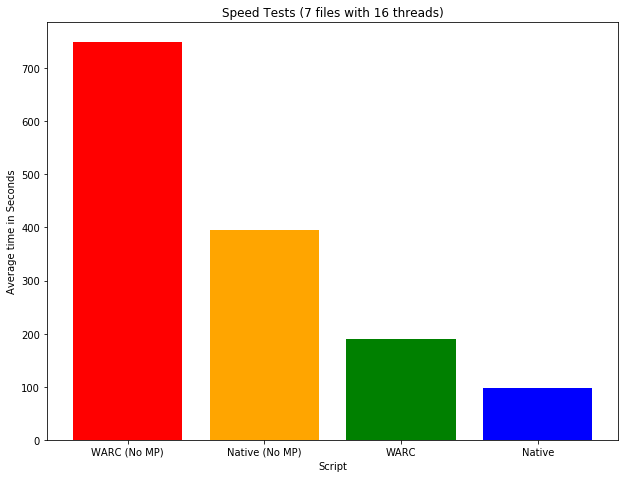

In [6]:
fig, ax = plt.subplots(figsize=(10.24,7.68))

wmp = 189
wnmp = 749
nmp = 98
nnmp = 396
plt.bar("WARC (No MP)", wnmp, color='red')
plt.bar("Native (No MP)", nnmp, color='orange')
plt.bar("WARC", wmp, color='green')
plt.bar("Native", nmp, color='blue')
plt.xlabel('Script')
plt.ylabel('Average time in Seconds')
plt.title('Speed Tests (7 files with 16 threads)')
plt.show()

*__Figure 2__: Speed Tests*

## Counter development

Development of the counters did nor require as much troubleshooting as the onion finder did. The initial thought process was to pull the onions and websites from each CSV into another CSV. In that CSV the counts from each individual CSV were compiled; next the script opned that file and took any duplicate domain and its associated count and combined them. This removed all duplicates from the file but preserved the counts. The script then went through and sorted each domain by its count. The process was then repeated for the clear web sites. The method was not pretty, but got the job done. After further research and with help from Mr. King, the script was drastically minimized. This was done by forcing the script to compile all the CSVs into one dump file. The script will then use the pandas library to identify and remove duplicate domains and combine their counts. It then sorted the domains and saved the results to a another CSV.

### Common Crawl Results

The scripts ran on Aquamentus for approximatley 4 days. From the September Common Crawl Corpus, 40239 unique onion doains were discovered accross 6443 unique clear web sites. This was a 348% increase from the very first run with provided 5400 domains, and a 4% increase from the script Mr. King ran. This was likely due to the script checking the URL itself for onions as well as the extracted content. Out of the 40239 unique domains, 32966 were v2 domains and 7273 were v3 domains. TOR maintains a metric counting the amount of unique v2 domains on their network. The month of September had approximatley 75000 active domains. This means we found about 44% of the active domains that were active (See Figure 3 for a visualized comparison). 

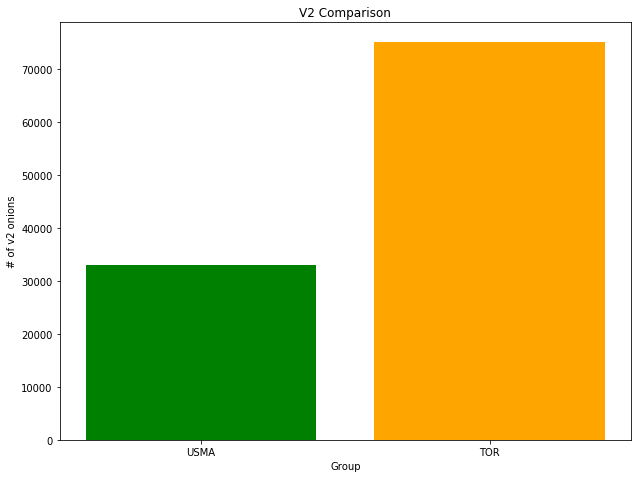

In [5]:
fig, ax = plt.subplots(figsize=(10.24,7.68))

usma = 32966
tor = 75000
plt.bar("USMA", usma, color='g')
plt.bar("TOR", tor, color='orange')
plt.xlabel('Group')
plt.ylabel('# of v2 onions')
plt.title('V2 Comparison')
plt.show()

*__Figure 3__: Visual comparison*

## Analysis

Using this database, we conducted an analysis of our results.

### Top 10 Onions and Sources - An In-Depth Look

From our data, we can take a look at just exactly which services on the Dark Web are most popular on the Clear Web. Taking a look at the top 10 sites, we see the following Figure 4


0

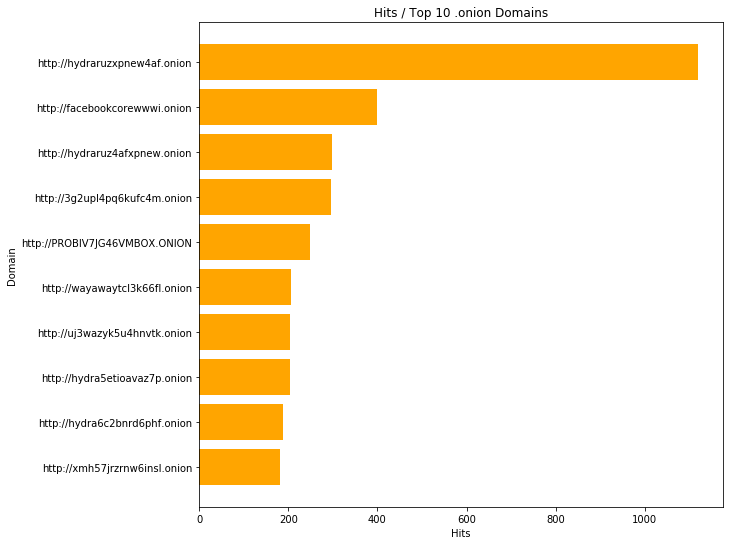

In [2]:
domain_fig, domain_ax = plt.subplots(figsize=(10.24,7.68))

dframeD = pd.read_sql_query("select * from domains order by hits desc limit 10",
                engine)
titleD = dframeD['title']
domainD = dframeD['domain']
hitsD = dframeD['hits']

plt.barh(domainD,hitsD,align='center',color='orange')
plt.xlabel('Hits')
plt.ylabel('Domain')
domain_ax.invert_yaxis()
plt.title('Hits / Top 10 .onion Domains')
plt.tight_layout(w_pad=1)

canvasD = fg(domain_fig)
img = BytesIO()
domain_fig.savefig(img)
img.seek(0)

*__Figure 4__: Top 10 domains*

Analyzing the top ten site involved navigating to the domain, interacting with the site, and querying google for extra information. This was done by utlizing a virutal machine (VM) with the Whonix OS. Whonix is a Linux distribution that focuses on anonymizing all of your web traffic and providing maximum security. This OS is safer when connecting to unknown onion sites due to its ability to 'sandbox' all applications, so should malware be installed it will be unable to determine the IP address of the host system.

Out of the ten domains, three failed to connect after multiple attempts, one was classified as adware, and the remaining six were sites for illegal activities. the following figures are screenshots of what each domain returned along with a short description.

### hydraruzxpnew4af.onion, hydra5etioavaz7p.onion, hydra6c2bnrd6phf.onion
![](Final_Images/hydraetio.png)
![](Final_Images/hydraref.png)

*__Figure 5__: Hydra market*


Hydra is a the top Russian marketplace on the darknet and very famous amount Russian speaking community. Hydra opened in 2015, providing a marketplace for illegal goods such as drugs and their ingredients, counterfeit documents and money, and hacking services. There is a reference at the bottom of each page, listing out the 7 active Hydra domains. There may be 7 as a remediation effort to keep their services up, should law enforcement seize the domain or should a hacker destroy it. What is also unique about Hydra is its decentralized nature-- there are many different vendors that pay rent to a central operator. This operator then gains license to operate as a Hydra affiliate, with vendors that pay extra becoming "trusted sellers" with extra privileges. So long as vendors maintain their monthly payments and abide by the rules set forth by the central hub, these vendors can continue to operate under the Hydra umbrella.[1]

### facebookcorewwwi.onion
![](Final_Images/fb.png)

*__Figure 6__: Facebook*

This is the dark web site for the Facebook. Has the same functionality as the clear web version, except all your traffic is encrypted. Facebook has been maintaining this service on the Dark Web since 2014 in order to allow people to use their service in countries blocking Facebook. Facebook has reported that their Dark Web service has been garnering traffic of over 1 million users monthly.[2]

### hydraruz4afxpnew.onion
![](Final_Images/hydraruz4af.png)

*__Figure 7__: First failure*

This dark web address provides a connection error. This could be due to one of three things: it does not exist, does not run on port 80, exists but is currently offline.

### 3g2upl4pq6kufc4m.onion
![](Final_Images/3g2.png)

*__Figure 8__: DuckDuckGo*

This is the dark web site for the DuckDuckGo search engine. DuckDuckGo is a privacy-oriented search engine that allows users to navigate the internet without fear of personal information being leaked.

### probiv7jg46vmbox.onion
![](Final_Images/probiv.png)

*__Figure 9__: Probiv*

Probiv is a Russian-language slang term best translated as ‚Äúlook-up‚Äù. This dark web domain focuses on the distribution of personally identifiable information (PII) for a price. Primary users are criminals and private investigators.[3]

### wayawaytcl3k66fl.onion
![](Final_Images/wayaway.png)

*__Figure 10__: Second failure*

This dark web address provides a connection error. This could be due to one of three things: it does not exist, does not run on port 80, exists but is currently offline.

### uj3wazyk5u4hnvtk.onion
![](Final_Images/uj3.png)

*__Figure 11__: Third failure*

This dark web address provides a connection error. This could be due to one of three things: it does not exist, does not run on port 80, exists but is currently offline.

### xmh57jrzrnw6insl.onion
![](Final_Images/xmh.png)

*__Figure 12__: TORCH*

Torch or TorSearch is at search engine for the dark web. They claim to be the best, oldest, and longest running search engine for the dark web. This search engine is only available at the dark web address above and via the TOR browser're also the oldest and longest running search engine on Tor. This site is also classified as adware.

We can also look at the sources in a similar fashion and determine which sites are utilized the most to publish *.onion* addresses.

0

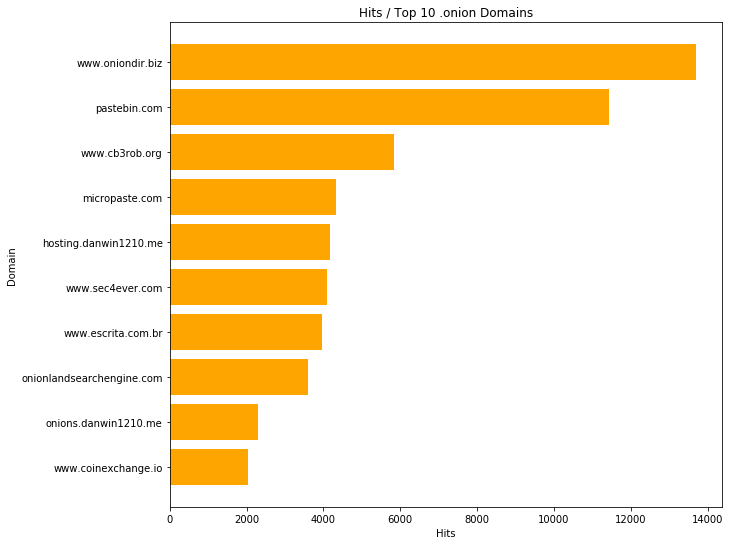

In [3]:
domain_fig, domain_ax = plt.subplots(figsize=(10.24,7.68))

dframeD = pd.read_sql_query("select * from sources order by hits desc limit 12",
                engine).drop([2,8])
# We drop entries 2 and 8 due to the fact that they are duplicate entries
titleD = dframeD['domain']
hitsD = dframeD['hits']

plt.barh(titleD,hitsD,align='center',color='orange')
plt.xlabel('Hits')
plt.ylabel('Domain')
domain_ax.invert_yaxis()
plt.title('Hits / Top 10 .onion Domains')
plt.tight_layout(w_pad=1)

canvasD = fg(domain_fig)
img = BytesIO()
domain_fig.savefig(img)
img.seek(0)

The one with the most references by far is a directory for *.onion* addresses, oniondir.biz. The number of hits for this address is over 14,000, more than doubling the number of hits for any single domain ranked 3 through 10.

At second, we have Pastebin, which is a popular site that hosts text files of all kinds. Since Pastebin is frequently used by hackers, programmers, and information sharers of all varieties, its place at the number 2 slot is understandable.

Covering third, we can see the domain for CyberBunker, a former hosting service for Dark Web domains. Due to several raids by German authorities, the service has since been taken down.[5] Instead, the address now redirects to a gab.com address for Sven Olaf Kamphuis' account, the hacker and former owner of CyberBunker.[6] The website gab.com is an alternative to Twitter marketed towards alt-right individuals.

The fourth slot is held by Micropaste, a service for sharing code, texts, and links, similar to Pastebin.

Next is hosting.danwin. This site is run by Daniel Winzen, who in turn hosts thousands of addresses on the Dark Web. However, as of March 2020, his service was attacked and most of his services were taken down.[7]

Sec4ever is an Arabic hacking forum and comes in the sixth slot of domains with the most unique *.onion* addresses within its contents. This comes as some surprise due to Arabic speaking nations not being associated on the forefront of hacking and cybersecurity. Nevertheless, Iran constitutes a major source of cyberattacks, and Arabic-speaking nations constitute a notable portion of the world's population.

In the seventh slot is www.escrita.com.br, a Brazilian library/archive site. According to the translated landing page, the site allows writers to submit content for publication. This covers a wide variety of content, to include news, essays, poetry, and reviews.

Next is onionlandsearchengine, which is a search engine for the Dark Web. It is interesting to note that as a search engine, onionland only accounts for less than 4000 unique domains on its site and is dwarfed by listings from even hosting sites.

Again we see Daniel Winzen's domain, but this time it appears to be a listing of onions on his site.

Finally, we see coinexchange.io, which is a domain dedicated to BTC trading. With Bitcoin being the de facto currency of the Dark Web, it makes sense that an exchange would link to a large number of *.onion* addresses.

---

### Ranking by Hits

We can also plot the ranking trends to see exactly how the hits are distributed across our dataset. Doing this we get

0

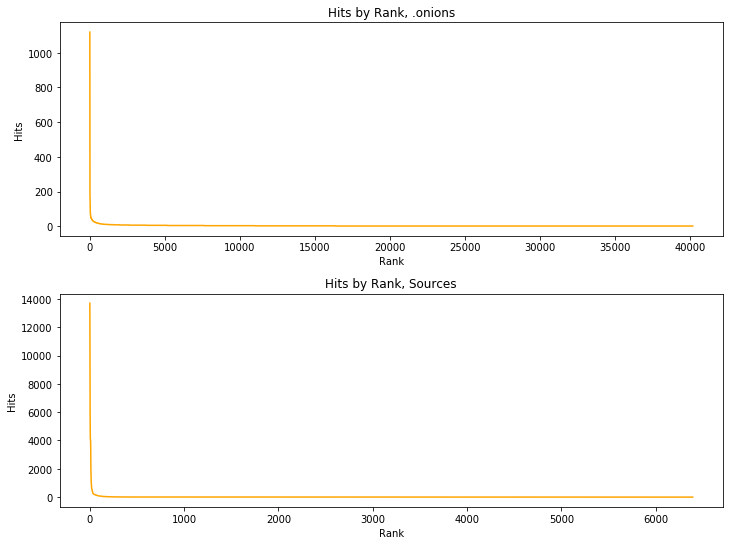

In [4]:
domain_fig, (ax1,ax2) = plt.subplots(2,figsize=(10.24,7.68))

dframe1 = pd.read_sql_query("select * from domains order by hits desc",
                engine)
title1 = dframe1['title']
hitRank1 = []
for i in range(0,len(title1)):
    hitRank1.append(i)
hits1 = dframe1['hits']

dframe2 = pd.read_sql_query("select * from sources order by hits desc",
                engine)
hits2 = dframe2['hits']
hitRank2 = []
for i in range(0,len(hits2)):
    hitRank2.append(i)

ax1.plot(hitRank1,hits1,color='orange')
ax1.set_title('Hits by Rank, .onions')

ax2.plot(hitRank2,hits2,color='orange')
ax2.set_title('Hits by Rank, Sources')

for ax in (ax1,ax2):
    ax.set(xlabel='Rank',ylabel='Hits')

plt.tight_layout(w_pad=1)

canvasD = fg(domain_fig)
img = BytesIO()
domain_fig.savefig(img)
img.seek(0)

Looking at these diagrams, one thing stands out: the vast majority of hits come from the upper portion of both sources and *.onion* addresses. In fact, based on some cursory SQL queries, we determined that for our *.onion* table, the top 10% of addresses accounted for nearly 50% of the hits. Additionally, over 90% of *.onion* hits were contained within the top 10% of sources.

There are several implications that one could derive from this:

1. By monitoring only a small subset of sites on the clear web, one can find a large proportion of the hidden services on the Dark Web.
2. By monitoring only a small subset of sites on the Dark Web, one can track the majority of the traffic on the Dark Web.
3. While the numbers do not exactly match the Pareto Principle, a threat analyst can use the following rule of thumb: 20% of the Dark Web is liable to cause 80% of your problems.

---


### Breakdown of .onion Statuses and Responses

We can now observe the timestamps and statuses of the most recent round of requests we performed on our list of *.onion* addresses. From this set of data, we can see all of the requests grouped by response code, *e.g.* HTTP 200, 300, 400, and 500.

We grouped these requests into the following status groups:

- **200** : The request returned a valid response, and information from the address was likely successfully logged.
- **300** : The request returned a response indicating the service has moved to another location or redirects elsewhere.
- **400** : The request returned a client error, e.g. bad response, unauthorized, forbidden, etc.
- **500** : The request returned a server error, e.g. service unavailable.
- **Connect Timeout** : The request failed to receive a response within the allotted time limit.
- **SSLError** : The SSL certificate for the service is untrusted, indicating potential for malicious activity.
- **Attribute Error** : Likely a failure to parse information from the service in our script.
- **Read Timeout** : The request succeeded, but the response timed out returning information.
- **Connection Error** : An error indicating a connection failure, possibly because the address is not hosting a webserver on a standart port.

Of these, the most interesting status was the Connection Error. Upon initial reading, the response is nondescript. However, this response indicates potential for a service being hosted on a nonstandard port, meaning a service may very well exist, hidden from prying eyes.

Graphing our results, we get

0

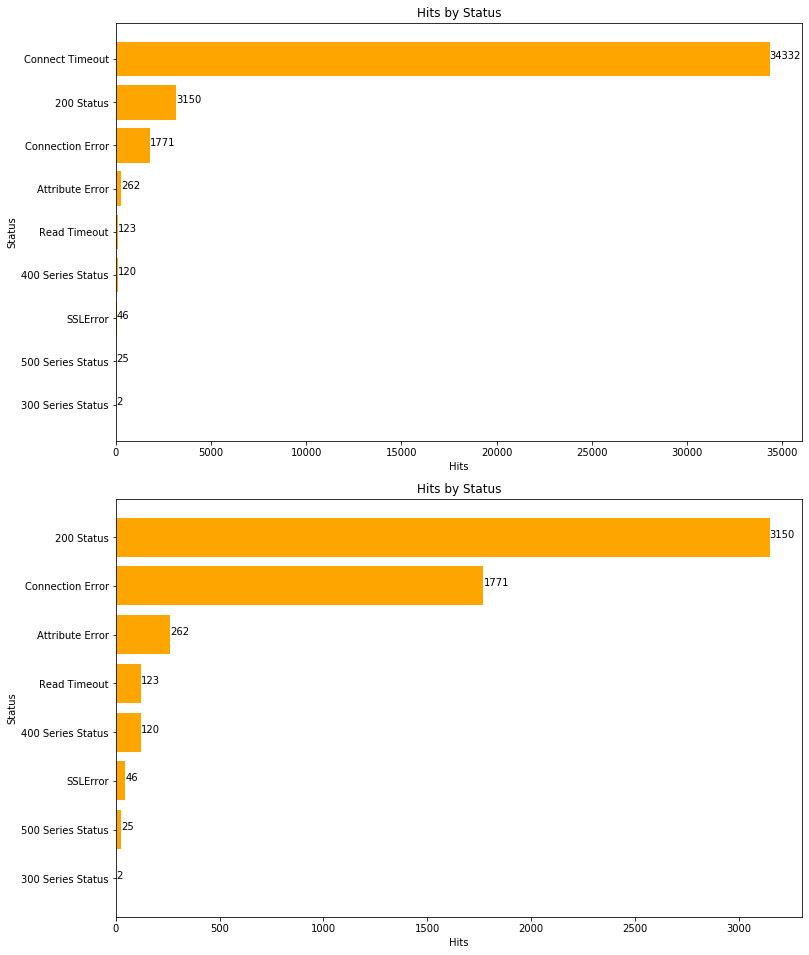

In [24]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(11.36,13.37))

status = pd.read_sql_query("select count(*) from timestamps where timestamp like '%04/%' and status='200'",
                engine)
status = status.rename(index={0: 1})
status = status.append(pd.read_sql_query("select count(*) from timestamps where timestamp like '%04/%' and status like '%30%'",
                engine))
status = status.rename(index={0: 2})
status = status.append(pd.read_sql_query("select count(*) from timestamps where timestamp like '%04/%' and status like '%40%'",
                engine))
status = status.rename(index={0: 3})
status = status.append(pd.read_sql_query("select count(*) from timestamps where timestamp like '%04/%' and status like '%50%'",
                engine))
status = status.rename(index={0: 4})
status = status.append(pd.read_sql_query("select count(*) from timestamps where timestamp like '%04/%' and status='ConnectTimeout'",
                engine))
status = status.rename(index={0: 5})
status = status.append(pd.read_sql_query("select count(*) from timestamps where timestamp like '%04/%' and status='SSLError'",
                engine))
status = status.rename(index={0: 6})
status = status.append(pd.read_sql_query("select count(*) from timestamps where timestamp like '%04/%' and status like '%Attribute%'",
                engine))
status = status.rename(index={0: 7})
status = status.append(pd.read_sql_query("select count(*) from timestamps where timestamp like '%04/%' and status like '%Read%'",
                engine))
status = status.rename(index={0: 8})
status = status.append(pd.read_sql_query("select count(*) from timestamps where timestamp like '%04/%' and status like '%Connection%'",
                engine))
status = status.rename(columns={'count(*)': 'Hits'}, index={0: 9})
status = status.rename(index={1:0,2:1,3:2,4:3,5:4,6:5,7:6,8:7,9:8})

newCol = pd.DataFrame(['200 Status',
                       '300 Series Status',
                       '400 Series Status',
                       '500 Series Status',
                       'Connect Timeout',
                       'SSLError',
                       'Attribute Error',
                       'Read Timeout',
                       'Connection Error'],columns=['Status'])

dframe = pd.DataFrame({'Status': newCol['Status'],
                       'Hits': status['Hits']}).sort_values('Hits',ascending=False)

ax1.set_title('Hits by Status')
ax2.set_title('Hits by Status')

bar1 = ax1.barh(dframe['Status'],dframe['Hits'],align='center',color='orange')
ax1.invert_yaxis()

bar2 = ax2.barh(dframe['Status'].drop([4]),dframe['Hits'].drop([4]),align='center',color='orange')
ax2.invert_yaxis()

for index, value in enumerate(dframe['Hits']):
    ax1.text(value, index, value)
for index, value in enumerate(dframe['Hits'].drop([4])):
    ax2.text(value, index, value)

for ax in (ax1, ax2):
    ax.set(xlabel='Hits',ylabel='Status')

plt.tight_layout(w_pad=1)

canvasD = fg(fig)
img = BytesIO()
fig.savefig(img)
img.seek(0)

In the first chart, we included the Connect Timeout errors. As can be seen in this chart, Timeouts accounted for the majority of responses for our complete list of *.onion* addresses, with over 34,000 addresses returning this response. Looking forward, we will likely rerun these addresses through our script with an increased timeout limit, and we anticipate that by doing this, we will enhance the completeness of our database.

Controlling for Connect Timeout responses, we see the second chart. The second most common response was a valid HTTP 200 response. Over 3,000 addresses were able to be connected to, just under 10% of the addresses we gathered. Though it seems like a low number, this is still a powerful insight into the Dark Web, albeit improvable.

We also see just over 1,700 Connection Errors. While some of these may be legitimate errors, it is likely that a sizeable chunk of these addresses are running services on nonstandard ports. In the future, we hope to investigate these particular status codes further in order to determine their exact purpose and orientation.

Formatting this information into a more human-readable graphic, we see below

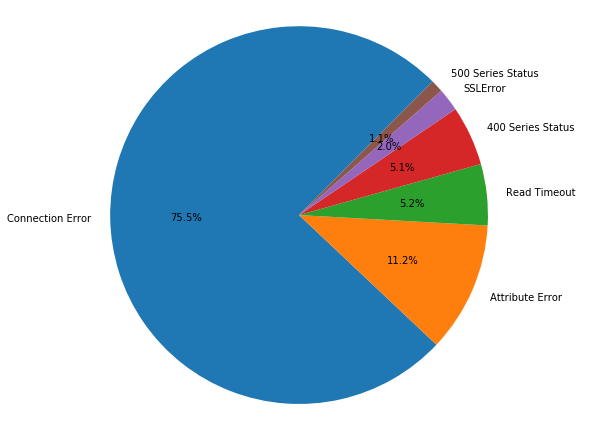

In [6]:
fig, ax = plt.subplots(figsize=(10.24,7.68))

labels = dframe['Status'].drop([0,4,1])
sizes = dframe['Hits'].drop([0,4,1])

ax.pie(sizes,labels=labels,autopct='%1.1f%%',startangle=45)
ax.axis('equal')

plt.show()

Out of all the statuses aside from 200 OK and Connect Timeout, we see that Connection Errors account for three quarters of the remaining statuses.

16% of these remainders-- Read Timeouts and Attribute Errors, can likely return a valid response after tweaking our codebase to account for these errors. We hope to apply these improvements in the near future to enhance our database.

---

### Categorization by Language

We can also break down our results by language and determine which countries are more likely to utilize the Dark Web.

       Count
en      2014
de       250
ru        99
da        93
nl        73
af        70
it        66
no        57
fr        55
pt        49
tl        44
ro        41
es        40
so        34
sv        32
ca        32
id        30
sw        26
vi        25
fi        25
pl        23
cy        19
zh-cn     17
sl        15
bg        14
et        14
N/A       12
hr        10
lt         9
hu         8
tr         7
sq         6
cs         5
he         4
ko         4
lv         2
sk         2
mk         2
uk         2
ja         2


0

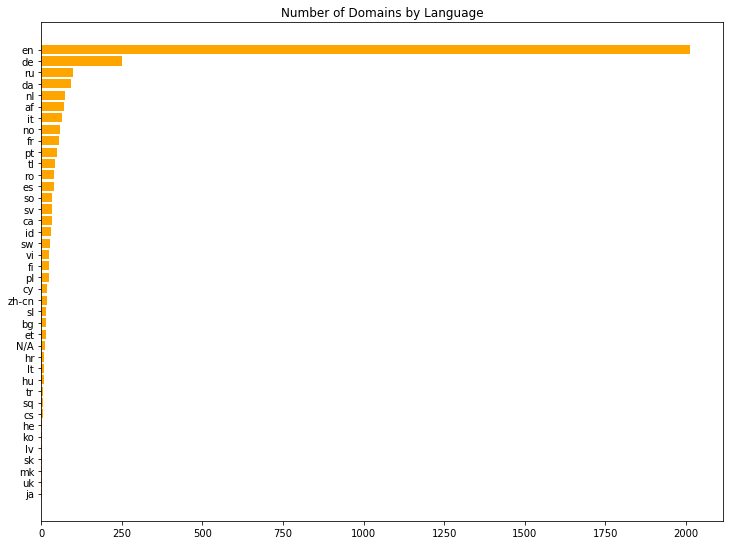

In [32]:
DetectorFactory.seed = 0

fig, ax = plt.subplots(figsize=(10.24,7.68))

queryframe = pd.read_sql_query("select * from domains where title not like 'N/A' order by hits desc", engine)
langlist = []
langdict = {}

for item in queryframe['title']:
    try:
        detection = detect(str(item))
        langlist.append(detection)
    except Exception as e:
        langlist.append('N/A')
        
for item in langlist:
    if item not in langdict:
        langdict[item] = 1
    else:
        langdict[item] += 1
        
newdframe = pd.DataFrame.from_dict(langdict, orient='index',
                       columns=['Count']).sort_values('Count',ascending=False)

ax.set_title('Number of Domains by Language')

print(newdframe)

bar = ax.barh(newdframe.index,newdframe['Count'],align='center',color='orange')
ax.invert_yaxis()

plt.tight_layout(w_pad=1)

canvasD = fg(fig)
img = BytesIO()
fig.savefig(img)
img.seek(0)

In [41]:
assessframe = pd.DataFrame({'Title': queryframe['title'],
                       'Language': langlist})

for item in range(0,len(assessframe.index)):
    print(assessframe.loc[item])

Title       –í—ã –Ω–µ —Ä–æ–±–æ—Ç?
Language              ru
Name: 0, dtype: object
Title       Facebook - Connexion ou inscription
Language                                     en
Name: 1, dtype: object
Title       DuckDuckGo ‚Äî Privacy, simplified.
Language                                   en
Name: 2, dtype: object
Title       –í—ã –Ω–µ —Ä–æ–±–æ—Ç?
Language              ru
Name: 3, dtype: object
Title       –í—ã –Ω–µ —Ä–æ–±–æ—Ç?
Language              ru
Name: 4, dtype: object
Title       TORCH: Tor Search!
Language                    en
Name: 5, dtype: object
Title       –í—ã –Ω–µ —Ä–æ–±–æ—Ç?
Language              ru
Name: 6, dtype: object
Title       –í—ã –Ω–µ —Ä–æ–±–æ—Ç?
Language              ru
Name: 7, dtype: object
Title       –§–ª–∏–±—É—Å—Ç–∞ | –ö–Ω–∏–∂–Ω–æ–µ –±—Ä–∞—Ç—Å—Ç–≤–æ
Language                             ru
Name: 8, dtype: object
Title       Login - ProtonMail
Language                    en
Name: 9, dtype: object
Title       TorLinks | .onion Link List The Hidden Wiki De

Name: 225, dtype: object
Title       –ï–≤–≥–µ–Ω–∏–π –í–æ–ª—å–Ω–æ–≤ ‚Äî –≤ —Ä–µ–∞–ª—å–Ω–æ–π –∂–∏–∑–Ω–∏ –ù–∏–∫–∏—Ç–∞ –ö—É–≤–∏...
Language                                                   ru
Name: 226, dtype: object
Title       BITLOX
Language        de
Name: 227, dtype: object
Title       Brom Package Server
Language                     en
Name: 228, dtype: object
Title       share.riseup.net
Language                  sq
Name: 229, dtype: object
Title       403 Forbidden
Language               da
Name: 230, dtype: object
Title       404 Not Found
Language               en
Name: 231, dtype: object
Title       apk.li
Language        lv
Name: 232, dtype: object
Title       Globe 0.4.9
Language             sl
Name: 233, dtype: object
Title       Onion Identity Services - Get your fake passpo...
Language                                                   en
Name: 234, dtype: object
Title       MagusNet Info and Stuff
Language                         en
Name: 235, dtype: object
Title       \n\

Name: 456, dtype: object
Title       DarkMarket - —Ç–µ–Ω–µ–≤–æ–π —Ä—ã–Ω–æ–∫
Language                            ru
Name: 457, dtype: object
Title       Login - Apollon Market
Language                        en
Name: 458, dtype: object
Title       Index of /
Language            en
Name: 459, dtype: object
Title       SecureDrop | Protecting Journalists and Sources
Language                                                 en
Name: 460, dtype: object
Title       Infantile - No Rules Communications
Language                                     fr
Name: 461, dtype: object
Title       Crazy Dog Sex
Language               pl
Name: 462, dtype: object
Title       WEEDSTORE
Language           sw
Name: 463, dtype: object
Title        Links Dir Tor | Urls sites onion
Language                                   en
Name: 464, dtype: object
Title       Nintendocore Princess
Language                       pt
Name: 465, dtype: object
Title       Rahakott - Anonymous Multi-Cryptocurrency Onli...
Language  

Name: 666, dtype: object
Title       Cocaine Market
Language                en
Name: 667, dtype: object
Title       pfpmd
Language       lv
Name: 668, dtype: object
Title       Index of /
Language            en
Name: 669, dtype: object
Title       \nPenguinMixer - an Open Source Bitcoin Mixer\n
Language                                                 en
Name: 670, dtype: object
Title       hobe OnionMail Server
Language                       en
Name: 671, dtype: object
Title       easyVisa- easy profit
Language                       en
Name: 672, dtype: object
Title       MARKET
Language        sw
Name: 673, dtype: object
Title       tymeioigi OnionMail Server
Language                            en
Name: 674, dtype: object
Title       Arto Ter√§s - Debian Conference 1, Bordeaux 2-5...
Language                                                   en
Name: 675, dtype: object
Title       CC Guru ‚Äì LF credit card cashers
Language                                  en
Name: 676, dtype: object


Name: 908, dtype: object
Title       √úbersicht: Hochschule Bochum
Language                              de
Name: 909, dtype: object
Title        Teen Deepthroat | Amateur porn private collec...
Language                                                   en
Name: 910, dtype: object
Title       The Hidden Wiki
Language                 nl
Name: 911, dtype: object
Title       Cloned Credit Cards, Prepaid Cards, Paypal & W...
Language                                                   en
Name: 912, dtype: object
Title       FlexxCocaine NO1 Cocaine Provider 79% & 93% PU...
Language                                                   fr
Name: 913, dtype: object
Title       Polismyndigheten
Language                  af
Name: 914, dtype: object
Title       10+ terabytes
Language               en
Name: 915, dtype: object
Title       Login - Apollon Market
Language                        en
Name: 916, dtype: object
Title       You are Retarded
Language                  ro
Name: 917, dtype: object
T

Name: 1150, dtype: object
Title       ‚ù§Saturnette‚ù§
Language              no
Name: 1151, dtype: object
Title       Clone CC : No.1 Trusted onion site for Cloned ...
Language                                                   en
Name: 1152, dtype: object
Title       Nothing here
Language              en
Name: 1153, dtype: object
Title       Financial Oasis ‚Äì The Dark Side 
Language                                  en
Name: 1154, dtype: object
Title       502 Bad Gateway
Language                 so
Name: 1155, dtype: object
Title       H.M.M. Rona
Language             en
Name: 1156, dtype: object
Title       BitPharma - biggest european .onion drug store...
Language                                                   en
Name: 1157, dtype: object
Title       „Ñê„ÑÖÊûóÈ§ÖÂππ
Language       ko
Name: 1158, dtype: object
Title       Deep Web Hosting | Secured and Anonymous | Lin...
Language                                                   en
Name: 1159, dtype: object
Title       CHEAP EURO

Name: 1392, dtype: object
Title       Real Rape
Language           ro
Name: 1393, dtype: object
Title       ALIEN FORUM ‚Äì alien facts
Language                           en
Name: 1394, dtype: object
Title       Error: 500 Internal Server Error
Language                                  de
Name: 1395, dtype: object
Title       Card The World Verified Sellers
Language                                 en
Name: 1396, dtype: object
Title       DOUBLE YOUR BTC
Language                 so
Name: 1397, dtype: object
Title       Dramatic 3d Incest Porn Plus Incest Gallery Co...
Language                                                   en
Name: 1398, dtype: object
Title       \n        BitLaundry - For all your Bitcoin wa...
Language                                                   en
Name: 1399, dtype: object
Title       Rustic Cyberpunk
Language                  en
Name: 1400, dtype: object
Title       Red Room
Language          en
Name: 1401, dtype: object
Title        acid law had bro aim 
L

Name: 1650, dtype: object
Title       Beastiality and Animal Sex Archive - Zoo.cab
Language                                              en
Name: 1651, dtype: object
Title       Bitmessage-Home
Language                 da
Name: 1652, dtype: object
Title        ‰∏≠ÊñáÊöóÁΩë
Language    zh-cn
Name: 1653, dtype: object
Title        ‰∏≠ÊñáÊöóÁΩë
Language    zh-cn
Name: 1654, dtype: object
Title        ‰∏≠ÊñáÊöóÁΩë
Language    zh-cn
Name: 1655, dtype: object
Title       Yellow Brick
Language              en
Name: 1656, dtype: object
Title       Porn Videos - XONIONS - THE BEST ONION PORN SI...
Language                                                   en
Name: 1657, dtype: object
Title       GlobaLeaks
Language            et
Name: 1658, dtype: object
Title       Clone CC : No.1 Trusted onion site for Cloned ...
Language                                                   en
Name: 1659, dtype: object
Title       Plastic Marketplace
Language                     en
Name: 1660, dtype: object
Titl

Name: 1900, dtype: object
Title       500 Internal Server Error
Language                           de
Name: 1901, dtype: object
Title       Queen Galaxy
Language              so
Name: 1902, dtype: object
Title       403 - Forbidden
Language                 da
Name: 1903, dtype: object
Title       Quickcoke ‚Äì Cocaine to all the world, quickly.
Language                                                en
Name: 1904, dtype: object
Title       K√É¬ºchenstudio | New Radio
Language                           en
Name: 1905, dtype: object
Title       OnionDir - Adult
Language                  en
Name: 1906, dtype: object
Title       Free Disposable Email Addresses ¬ª Alt Address
Language                                               en
Name: 1907, dtype: object
Title       Cheek Gay Muscle Porn Video @ Whencesoever Fim...
Language                                                   en
Name: 1908, dtype: object
Title       Magic CP
Language          ca
Name: 1909, dtype: object
Title       Versed 

Name: 2133, dtype: object
Title       Lucky Lucas Instant Casino Games - Home
Language                                         es
Name: 2134, dtype: object
Title       403 Forbidden
Language               da
Name: 2135, dtype: object
Title       OnionDir - Adult
Language                  en
Name: 2136, dtype: object
Title       What you acquire might shock you
Language                                  en
Name: 2137, dtype: object
Title       VendorPro - Best PayPal & Bank Account Vendor ...
Language                                                   en
Name: 2138, dtype: object
Title       Onion Browser Tor Check
Language                         en
Name: 2139, dtype: object
Title       Cloned cards, & PayPal & Western Union
Language                                        en
Name: 2140, dtype: object
Title       Freedom Hosting Reloaded
Language                          en
Name: 2141, dtype: object
Title       HQER - High Quality Euro Counterfeits - best c...
Language                    

Name: 2369, dtype: object
Title       Boy child forbidden | Porn boy cp
Language                                   en
Name: 2370, dtype: object
Title       Buy Gift Cards, eGift Cards Online - Gift Card...
Language                                                   en
Name: 2371, dtype: object
Title       Accueil | Hack2G2
Language                   de
Name: 2372, dtype: object
Title       Front Line Defenders |
Language                        de
Name: 2373, dtype: object
Title       Digital Thrift Shop ‚Äì Best digital stuff in To...
Language                                                   en
Name: 2374, dtype: object
Title       Freedom Finance - MoneyGram - Moneybookers - W...
Language                                                   en
Name: 2375, dtype: object
Title       HACK-HELP
Language           vi
Name: 2376, dtype: object
Title       CHEAP EUROS
Language             pt
Name: 2377, dtype: object
Title       LINKS Onion Web Link Directory - Hidden Wiki M...
Language        

Name: 2602, dtype: object
Title       Empire Market
Language               no
Name: 2603, dtype: object
Title       TrashPorn
Language           en
Name: 2604, dtype: object
Title       FURY HITMAN
Language             de
Name: 2605, dtype: object
Title       Index of /
Language            en
Name: 2606, dtype: object
Title       Smart Drum Robot
Language                  de
Name: 2607, dtype: object
Title       boxs
Language      so
Name: 2608, dtype: object
Title       World CP
Language          en
Name: 2609, dtype: object
Title       100x Your Coins in 24 Hours - Officially Hidde...
Language                                                   en
Name: 2610, dtype: object
Title       Rent-A-Hacker - Hire a hacker for every job yo...
Language                                                   en
Name: 2611, dtype: object
Title       Rape and murder! Shock photo and video! Killin...
Language                                                   en
Name: 2612, dtype: object
Title       CP VID

Name: 2854, dtype: object
Title       ChipMixer - Bitcoin Tumbler
Language                             en
Name: 2855, dtype: object
Title       The Archive
Language             en
Name: 2856, dtype: object
Title       \n    all computers are broken\n  
Language                                    en
Name: 2857, dtype: object
Title       BLOOD RAYNE - 
Language                vi
Name: 2858, dtype: object
Title       Tickets, please - Uberspace.de
Language                                en
Name: 2859, dtype: object
Title       bghost.xyz
Language            en
Name: 2860, dtype: object
Title       Startseite - Young & Yourself Bielefeld
Language                                         de
Name: 2861, dtype: object
Title       The Archive
Language             en
Name: 2862, dtype: object
Title       SecureDrop | Protecting Journalists and Sources
Language                                                 en
Name: 2863, dtype: object
Title       Angelo Gladding
Language                 tl
Name

Name: 3093, dtype: object
Title       List lolita porn | Urls CP kids - Wiki childre...
Language                                                   en
Name: 3094, dtype: object
Title       Your Hacking Center - Let Us Know What You Nee...
Language                                                   en
Name: 3095, dtype: object
Title       Crypton.sh - Secure physical phone number in t...
Language                                                   en
Name: 3096, dtype: object
Title       404 Not Found
Language               en
Name: 3097, dtype: object
Title       Les √©lections europ√©ennes de 2019
Language                                   fr
Name: 3098, dtype: object
Title       Sipulimarket
Language              id
Name: 3099, dtype: object
Title       401 Authorization Required
Language                            en
Name: 3100, dtype: object
Title       Á∫¶‰ºäÂÖπÁöÑËêåÁãº‰π°ÊâãÊú≠
Language        zh-cn
Name: 3101, dtype: object
Title       Ssh Tunnels - –°–µ—Ä–≤–∏—Å –ø–æ –ø—Ä–æ–¥–∞–∂–µ

## References

[1] https://www.vice.com/en_us/article/g5x3zj/hydra-russia-drug-cartel-dark-web

[2] https://www.businessinsider.com/facebook-tor-connect-1-million-2016-4

[3] https://www.digitalshadows.com/blog-and-research/probiv-the-missing-pieces-to-a-cybercriminals-puzzle/

[4] https://torrentfreak.com/the-pirate-bay-moves-to-a-brand-new-onion-domain-191206/

[5] https://krebsonsecurity.com/tag/cyberbunker/

[6] https://gab.com/cb3rob

[7] https://www.zdnet.com/article/dark-web-hosting-provider-hacked-again-7600-sites-down/